# Grid Search
Let's incorporate grid search into your modeling process. To start, include an import statement for `GridSearchCV` below.

In [1]:
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kaiqu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kaiqu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kaiqu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [3]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

### View parameters in pipeline
Before modifying your build_model method to include grid search, view the parameters in your pipeline here.

In [4]:
pipeline = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('starting_verb', StartingVerbExtractor())
    ])),

    ('clf', RandomForestClassifier())
])

In [5]:
pipeline.get_params()

{'memory': None,
 'steps': [('features',
   FeatureUnion(transformer_list=[('text_pipeline',
                                   Pipeline(steps=[('vect',
                                                    CountVectorizer(tokenizer=<function tokenize at 0x0000020DAB260828>)),
                                                   ('tfidf',
                                                    TfidfTransformer())])),
                                  ('starting_verb', StartingVerbExtractor())])),
  ('clf', RandomForestClassifier())],
 'verbose': False,
 'features': FeatureUnion(transformer_list=[('text_pipeline',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(tokenizer=<function tokenize at 0x0000020DAB260828>)),
                                                 ('tfidf',
                                                  TfidfTransformer())])),
                                ('starting_verb', StartingVerbExtractor())]

### Modify your `build_model` function to return a GridSearchCV object.
Try to grid search some parameters in your data transformation steps as well as those for your classifier! Browse the parameters you can search above.

In [6]:
def build_model():
    pipeline = Pipeline([
        ('features', FeatureUnion([
            
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),
    
        ('clf', RandomForestClassifier())
    ])

    # specify parameters for grid search
    parameters = {'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
                #'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
                #'features__text_pipeline__vect__max_features': (None, 5000, 10000),
                'features__text_pipeline__tfidf__use_idf': (True, False),
                'clf__n_estimators': [50, 100, 200],
               # 'clf__min_samples_split': [2, 3, 4],
                'features__transformer_weights': (
                    {'text_pipeline': 1, 'starting_verb': 0.5},
                    #{'text_pipeline': 0.5, 'starting_verb': 1},
                    #{'text_pipeline': 0.8, 'starting_verb': 1},
        )
    }

    # create grid search object
    cv = GridSearchCV(pipeline, param_grid = parameters)
    
    return cv

### Run program to test
Running grid search can take a while, especially if you are searching over a lot of parameters! If you want to reduce it to a few minutes, try commenting out some of your parameters to grid search over just 1 or 2 parameters with a small number of values each. Once you know that works, feel free to add more parameters and see how well your final model can perform! You can try this out in the next page.

Labels: ['Action' 'Dialogue' 'Information']
Accuracy: 0.961730449251248

Best Parameters: {'clf__n_estimators': 200, 'features__text_pipeline__tfidf__use_idf': True, 'features__text_pipeline__vect__ngram_range': (1, 1), 'features__transformer_weights': {'text_pipeline': 1, 'starting_verb': 0.5}}


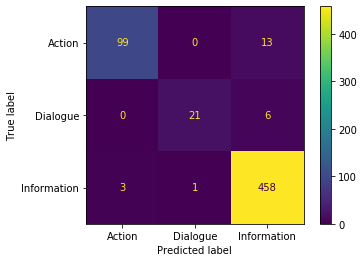

In [7]:
def load_data():
    df = pd.read_csv('../Data/corporate_messaging.csv', encoding='latin-1')
    df = df[(df["category:confidence"] == 1) & (df['category'] != 'Exclude')]
    X = df.text.values
    y = df.category.values
    return X, y


def display_results(cv, y_test, y_pred, estimator, X_test):
    labels = np.unique(y_pred)
    plot_confusion_matrix(estimator, X_test, y_test, labels=labels)
    

    print("Labels:", labels)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nBest Parameters:", cv.best_params_)


def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = build_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    display_results(model, y_test, y_pred, model, X_test)


main()